# Spatial Autoregressive Model with Panel Data

This notebook demonstrates spatial autoregressive modeling using panel data with spatial dependency. We simulate time series data for multiple spatial units (suburbs) and incorporate spatial relationships through connectivity matrices.

## Problem Setup
- Panel data: 10 spatial units (suburbs) × time series
- Time period: 2000 Q1 to 2025 Q4 (quarterly data)
- Spatial dependency: Suburbs influence each other through spatial connections
- Model: Spatial Autoregressive (SAR) with time lags
- Weighted Least Squares: Handle unreliable observations across space and time


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.regression.linear_model import WLS
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## 1. Generate Panel Data for Spatial Units


In [2]:
# Generate time series from 2000 Q1 to 2025 Q4
quarters = pd.date_range(start='2000-01-01', end='2025-12-31', freq='Q')
n_periods = len(quarters)

# Define spatial units (suburbs)
n_spatial_units = 10
suburbs = [f'Suburb_{i+1}' for i in range(n_spatial_units)]

# True spatial autoregressive parameters
spatial_rho = 0.3  # Spatial autoregressive coefficient
true_ar_params = [0.2, 0.15, 0.1, 0.05, 0.02]  # Time lag coefficients
true_intercept = 8.0
true_noise_std = 1.5

print(f"Generated {n_periods} quarterly observations")
print(f"Spatial units: {n_spatial_units} suburbs")
print(f"Total observations: {n_periods * n_spatial_units}")
print(f"Date range: {quarters[0].strftime('%Y-%m')} to {quarters[-1].strftime('%Y-%m')}")
print(f"Suburbs: {suburbs}")


Generated 104 quarterly observations
Spatial units: 10 suburbs
Total observations: 1040
Date range: 2000-03 to 2025-12
Suburbs: ['Suburb_1', 'Suburb_2', 'Suburb_3', 'Suburb_4', 'Suburb_5', 'Suburb_6', 'Suburb_7', 'Suburb_8', 'Suburb_9', 'Suburb_10']


## 2. Create Spatial Connectivity Matrix


Spatial Connectivity Matrix (W):
Values represent spatial influence weights (row-normalized)
           Suburb_1  Suburb_2  Suburb_3  Suburb_4  Suburb_5  Suburb_6  \
Suburb_1      0.000     0.588     0.294     0.118     0.000     0.000   
Suburb_2      0.370     0.000     0.370     0.185     0.074     0.000   
Suburb_3      0.156     0.312     0.000     0.312     0.156     0.063   
Suburb_4      0.059     0.147     0.294     0.000     0.294     0.147   
Suburb_5      0.000     0.059     0.147     0.294     0.000     0.294   
Suburb_6      0.000     0.000     0.059     0.147     0.294     0.000   
Suburb_7      0.000     0.000     0.000     0.059     0.147     0.294   
Suburb_8      0.000     0.000     0.000     0.000     0.063     0.156   
Suburb_9      0.000     0.000     0.000     0.000     0.000     0.074   
Suburb_10     0.000     0.000     0.000     0.000     0.000     0.000   

           Suburb_7  Suburb_8  Suburb_9  Suburb_10  
Suburb_1      0.000     0.000     0.000      0.000

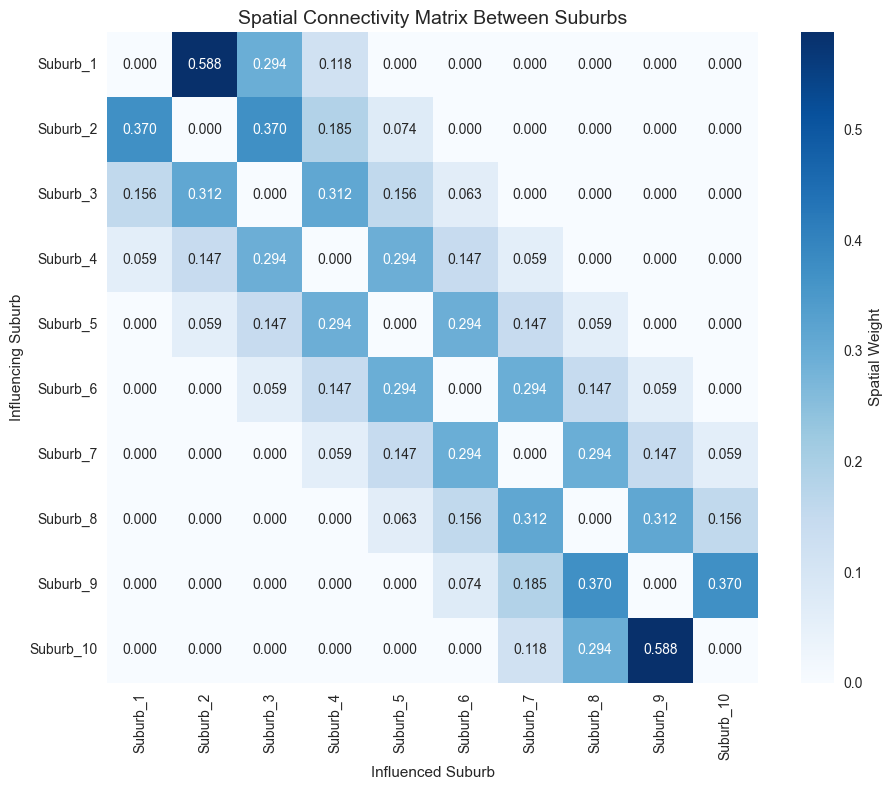

In [10]:
# Create spatial connectivity matrix (W matrix)
# This represents spatial relationships between suburbs
# Higher values indicate stronger spatial influence

def create_spatial_matrix(n_units, connection_strength=0.4):
    """Create a spatial connectivity matrix with spatial continuity structure"""
    W = np.zeros((n_units, n_units))
    
    # Create spatial continuity: nearby suburbs influence each other
    for i in range(n_units):
        for j in range(n_units):
            if i != j:
                # Distance-based influence (decreasing with distance)
                distance = abs(i - j)
                if distance == 1:  # Adjacent suburbs
                    W[i, j] = connection_strength
                elif distance == 2:  # Second neighbors
                    W[i, j] = connection_strength * 0.5
                elif distance == 3:  # Third neighbors
                    W[i, j] = connection_strength * 0.2
                # Beyond distance 3: no direct influence
    
    # Row normalize (each row sums to 1)
    row_sums = W.sum(axis=1)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    W = W / row_sums[:, np.newaxis]
    
    return W

# Create the spatial connectivity matrix
W = create_spatial_matrix(n_spatial_units, connection_strength=0.4)

# Convert to DataFrame for better visualization
W_df = pd.DataFrame(W, index=suburbs, columns=suburbs)

print("Spatial Connectivity Matrix (W):")
print("Values represent spatial influence weights (row-normalized)")
print(W_df.round(3))

# Visualize the spatial connectivity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(W_df, annot=True, cmap='Blues', fmt='.3f', 
            square=True, cbar_kws={'label': 'Spatial Weight'})
plt.title('Spatial Connectivity Matrix Between Suburbs', fontsize=14)
plt.xlabel('Influenced Suburb')
plt.ylabel('Influencing Suburb')
plt.tight_layout()
plt.show()


## 3. Simulate Spatial Autoregressive Panel Data


In [11]:
# Initialize panel data matrix
# Shape: (n_periods, n_spatial_units)
panel_data = np.zeros((n_periods, n_spatial_units))

# Generate initial values for each spatial unit
panel_data[:5, :] = np.random.normal(true_intercept, true_noise_std, (5, n_spatial_units))

# Generate spatial autoregressive time series
for t in range(5, n_periods):
    for i in range(n_spatial_units):
        # Spatial effect: influence from neighboring spatial units
        spatial_effect = spatial_rho * np.sum(W[i, :] * panel_data[t-1, :])
        
        # Time autoregressive effect
        time_ar_effect = np.sum(true_ar_params * panel_data[t-5:t, i])
        
        # Combine effects
        panel_data[t, i] = (true_intercept + spatial_effect + time_ar_effect + 
                           np.random.normal(0, true_noise_std))

# Add additional noise during unreliable period (2021-2022)
unreliable_mask = (quarters.year >= 2021) & (quarters.year <= 2022)
panel_data[unreliable_mask] += np.random.normal(0, 2.0, 
                                               (unreliable_mask.sum(), n_spatial_units))

# Convert to long format DataFrame
panel_list = []
for i, suburb in enumerate(suburbs):
    for t, quarter in enumerate(quarters):
        panel_list.append({
            'suburb': suburb,
            'date': quarter,
            'year': quarter.year,
            'quarter': quarter.quarter,
            'y': panel_data[t, i],
            'time_index': t,
            'spatial_index': i
        })

df = pd.DataFrame(panel_list)

print(f"Panel data shape: {panel_data.shape}")
print(f"DataFrame shape: {df.shape}")
print(f"Unreliable period observations: {unreliable_mask.sum() * n_spatial_units}")
print(f"\nFirst few rows:")
print(df.head(10))


Panel data shape: (104, 10)
DataFrame shape: (1040, 7)
Unreliable period observations: 80

First few rows:
     suburb       date  year  quarter          y  time_index  spatial_index
0  Suburb_1 2000-03-31  2000        1   6.225112           0              0
1  Suburb_1 2000-06-30  2000        2   8.576098           1              0
2  Suburb_1 2000-09-30  2000        3   7.905981           2              0
3  Suburb_1 2000-12-31  2000        4  10.947088           3              0
4  Suburb_1 2001-03-31  2001        1   7.587422           4              0
5  Suburb_1 2001-06-30  2001        2  13.491754           5              0
6  Suburb_1 2001-09-30  2001        3  16.360635           6              0
7  Suburb_1 2001-12-31  2001        4  19.507442           7              0
8  Suburb_1 2002-03-31  2002        1  19.823933           8              0
9  Suburb_1 2002-06-30  2002        2  17.407673           9              0


## 4. Create Time-Lagged Features and Spatial Lags


In [12]:
# Create time-lagged features for each spatial unit
for lag in range(1, 6):
    df[f'y_lag_{lag}'] = df.groupby('suburb')['y'].shift(lag)

# Create spatial lags (influence from neighboring spatial units)
def create_spatial_lags(df, W, suburbs):
    """Create spatial lag variables based on connectivity matrix"""
    spatial_lags = np.zeros(len(df))
    
    for idx, row in df.iterrows():
        suburb_idx = suburbs.index(row['suburb'])
        time_idx = row['time_index']
        
        # Calculate spatial lag as weighted average of neighbors
        spatial_lag = 0
        for j, neighbor in enumerate(suburbs):
            if W[suburb_idx, j] > 0:  # If there's a connection
                neighbor_data = df[(df['suburb'] == neighbor) & 
                                 (df['time_index'] == time_idx)]
                if not neighbor_data.empty:
                    spatial_lag += W[suburb_idx, j] * neighbor_data['y'].iloc[0]
        
        spatial_lags[idx] = spatial_lag
    
    return spatial_lags

# Add spatial lag variable
df['spatial_lag'] = create_spatial_lags(df, W, suburbs)

# Define weights: downweight unreliable period (2021-2022)
df['weights'] = np.where((df['year'] >= 2021) & (df['year'] <= 2022), 0.1, 1.0)
df['is_unreliable'] = (df['year'] >= 2021) & (df['year'] <= 2022)

# Remove rows with NaN values (first 5 observations for each suburb)
df_clean = df.dropna().reset_index(drop=True)

print(f"Clean panel dataset shape: {df_clean.shape}")
print(f"Unreliable observations: {df_clean['is_unreliable'].sum()}")
print(f"Weight range: {df_clean['weights'].min():.3f} to {df_clean['weights'].max():.3f}")

# Feature columns
feature_cols = ['y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4', 'y_lag_5', 'spatial_lag']

print(f"\nFeature columns: {feature_cols}")
print(f"\nSample of features:")
print(df_clean[['suburb', 'date', 'y'] + feature_cols + ['weights']].head(10))


Clean panel dataset shape: (990, 15)
Unreliable observations: 80
Weight range: 0.100 to 1.000

Feature columns: ['y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4', 'y_lag_5', 'spatial_lag']

Sample of features:
     suburb       date          y    y_lag_1    y_lag_2    y_lag_3    y_lag_4  \
0  Suburb_1 2001-06-30  13.491754   7.587422  10.947088   7.905981   8.576098   
1  Suburb_1 2001-09-30  16.360635  13.491754   7.587422  10.947088   7.905981   
2  Suburb_1 2001-12-31  19.507442  16.360635  13.491754   7.587422  10.947088   
3  Suburb_1 2002-03-31  19.823933  19.507442  16.360635  13.491754   7.587422   
4  Suburb_1 2002-06-30  17.407673  19.823933  19.507442  16.360635  13.491754   
5  Suburb_1 2002-09-30  23.330583  17.407673  19.823933  19.507442  16.360635   
6  Suburb_1 2002-12-31  24.817386  23.330583  17.407673  19.823933  19.507442   
7  Suburb_1 2003-03-31  25.394032  24.817386  23.330583  17.407673  19.823933   
8  Suburb_1 2003-06-30  26.697236  25.394032  24.817386  23.330583 

## 5. Visualize Panel Data and Spatial Relationships


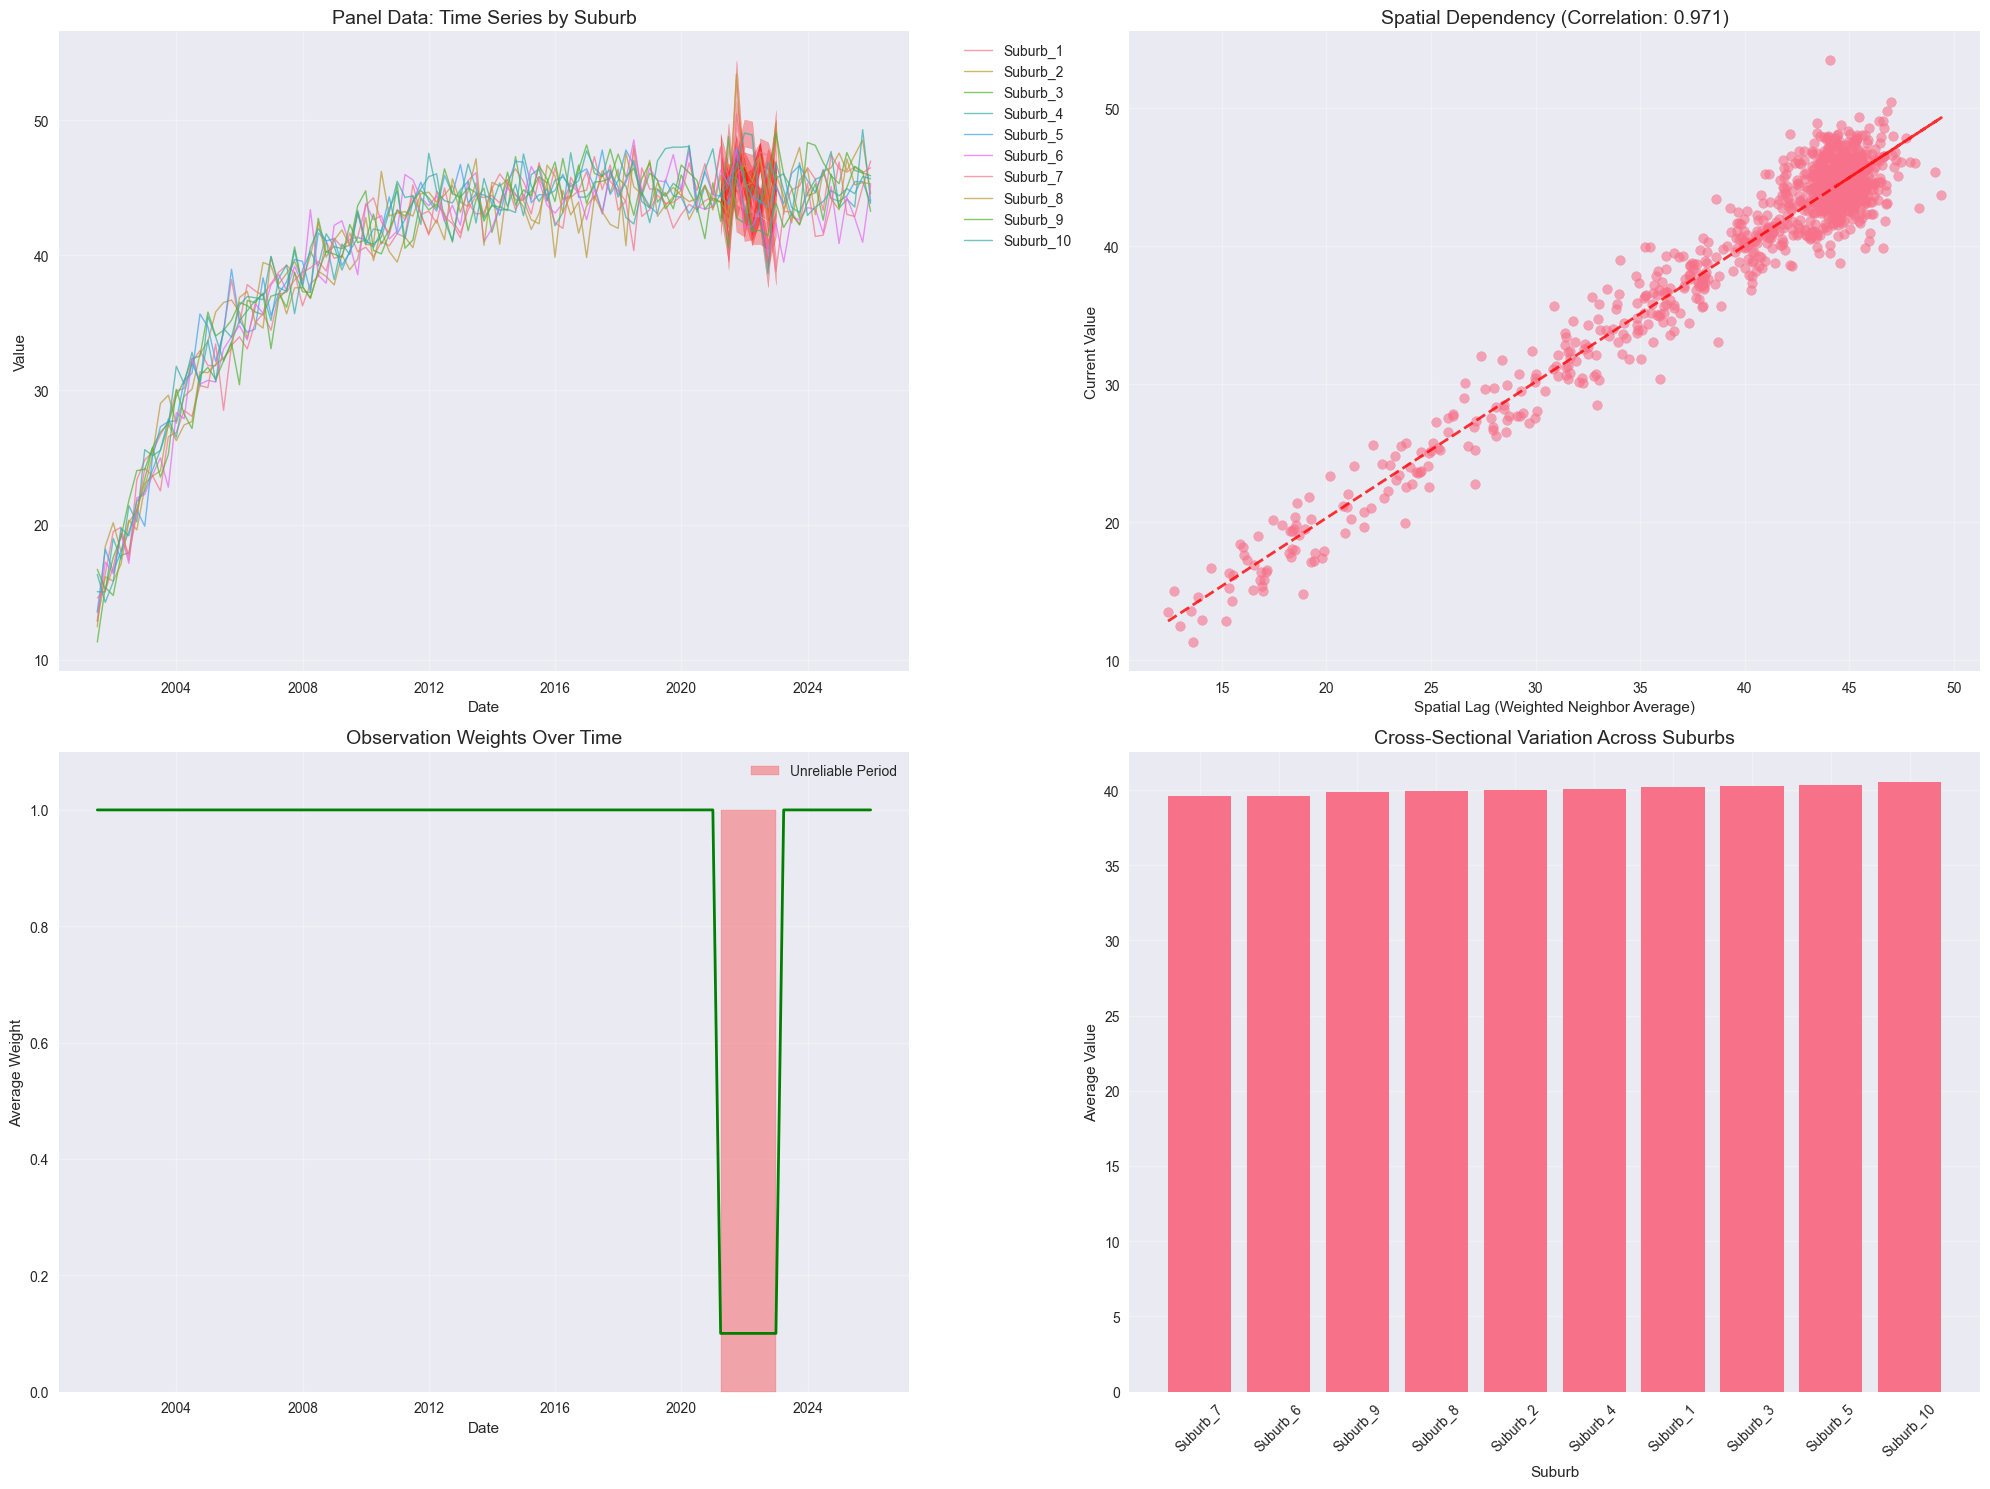

=== PANEL DATA SUMMARY ===
Total observations: 990
Spatial units: 10
Time periods: 99
Spatial correlation: 0.9711
Unreliable observations: 80
Average value by suburb:
suburb
Suburb_7     39.584
Suburb_6     39.608
Suburb_9     39.875
Suburb_8     39.929
Suburb_2     39.968
Suburb_4     40.100
Suburb_1     40.196
Suburb_3     40.268
Suburb_5     40.356
Suburb_10    40.518
Name: y, dtype: float64


In [13]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Plot 1: Time series for all spatial units
for i, suburb in enumerate(suburbs):
    suburb_data = df_clean[df_clean['suburb'] == suburb]
    axes[0, 0].plot(suburb_data['date'], suburb_data['y'], 
                   alpha=0.7, label=suburb, linewidth=1)

# Highlight unreliable period
unreliable_data = df_clean[df_clean['is_unreliable']]
if not unreliable_data.empty:
    for suburb in unreliable_data['suburb'].unique():
        sub_data = unreliable_data[unreliable_data['suburb'] == suburb]
        axes[0, 0].fill_between(sub_data['date'], sub_data['y'] - 1, 
                               sub_data['y'] + 1, alpha=0.3, color='red')

axes[0, 0].set_title('Panel Data: Time Series by Suburb', fontsize=14)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Spatial lag relationships
spatial_corr = df_clean[['y', 'spatial_lag']].corr().iloc[0, 1]
axes[0, 1].scatter(df_clean['spatial_lag'], df_clean['y'], alpha=0.6)
axes[0, 1].set_xlabel('Spatial Lag (Weighted Neighbor Average)')
axes[0, 1].set_ylabel('Current Value')
axes[0, 1].set_title(f'Spatial Dependency (Correlation: {spatial_corr:.3f})', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(df_clean['spatial_lag'], df_clean['y'], 1)
p = np.poly1d(z)
axes[0, 1].plot(df_clean['spatial_lag'], p(df_clean['spatial_lag']), 
               "r--", alpha=0.8, linewidth=2)

# Plot 3: Weights distribution over time
weights_by_time = df_clean.groupby('date')['weights'].mean()
axes[1, 0].plot(weights_by_time.index, weights_by_time.values, 'g-', linewidth=2)
axes[1, 0].fill_between(unreliable_data['date'].unique(), 0, 1, 
                       alpha=0.3, color='red', label='Unreliable Period')
axes[1, 0].set_title('Observation Weights Over Time', fontsize=14)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Average Weight')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0, 1.1)

# Plot 4: Cross-sectional variation
cross_sectional_means = df_clean.groupby('suburb')['y'].mean().sort_values()
axes[1, 1].bar(range(len(cross_sectional_means)), cross_sectional_means.values)
axes[1, 1].set_xlabel('Suburb')
axes[1, 1].set_ylabel('Average Value')
axes[1, 1].set_title('Cross-Sectional Variation Across Suburbs', fontsize=14)
axes[1, 1].set_xticks(range(len(cross_sectional_means)))
axes[1, 1].set_xticklabels(cross_sectional_means.index, rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("=== PANEL DATA SUMMARY ===")
print(f"Total observations: {len(df_clean)}")
print(f"Spatial units: {df_clean['suburb'].nunique()}")
print(f"Time periods: {df_clean['date'].nunique()}")
print(f"Spatial correlation: {spatial_corr:.4f}")
print(f"Unreliable observations: {df_clean['is_unreliable'].sum()}")
print(f"Average value by suburb:")
print(cross_sectional_means.round(3))


## 6. Fit Spatial Autoregressive Models


In [14]:
# Prepare data for modeling
X = df_clean[feature_cols].values
y = df_clean['y'].values
w = df_clean['weights'].values

# Add constant term for intercept
X_with_const = sm.add_constant(X)

print(f"Feature matrix shape: {X_with_const.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Weights shape: {w.shape}")

# 1. Ordinary Least Squares (OLS)
ols_model = sm.OLS(y, X_with_const).fit()
ols_predictions = ols_model.predict(X_with_const)

# 2. Weighted Least Squares (WLS)
wls_model = WLS(y, X_with_const, weights=w).fit()
wls_predictions = wls_model.predict(X_with_const)

# 3. Spatial Autoregressive Model (SAR) - Custom Implementation
# This is a simplified SAR model combining spatial and time effects
def fit_spatial_ar_model(y, X, W, spatial_units, time_indices):
    """
    Fit a spatial autoregressive model using iterative approach
    """
    from sklearn.linear_model import LinearRegression
    
    # Initial estimate without spatial effects
    initial_model = LinearRegression()
    initial_model.fit(X, y)
    initial_predictions = initial_model.predict(X)
    
    # Calculate spatial effects
    spatial_effects = np.zeros(len(y))
    for i, (spatial_idx, time_idx) in enumerate(zip(spatial_units, time_indices)):
        # Get neighbors for this spatial unit
        neighbor_indices = np.where(W[spatial_idx, :] > 0)[0]
        if len(neighbor_indices) > 0:
            # Find observations from neighbors at the same time
            neighbor_obs = []
            for j in range(len(y)):
                if (spatial_units[j] in neighbor_indices and 
                    time_indices[j] == time_idx):
                    neighbor_obs.append(initial_predictions[j])
            
            if neighbor_obs:
                spatial_effects[i] = np.mean(neighbor_obs)
    
    # Add spatial effects as additional feature
    X_with_spatial = np.column_stack([X, spatial_effects])
    
    # Fit final model
    sar_model = LinearRegression()
    sar_model.fit(X_with_spatial, y)
    sar_predictions = sar_model.predict(X_with_spatial)
    
    return sar_model, sar_predictions, spatial_effects

# Fit spatial autoregressive model
sar_model, sar_predictions, spatial_effects = fit_spatial_ar_model(
    y, X, W, df_clean['spatial_index'].values, df_clean['time_index'].values
)

# Calculate R² for SAR model
sar_r2 = r2_score(y, sar_predictions)

print("=== MODEL COMPARISON ===")
print(f"\nOLS R²: {ols_model.rsquared:.4f}")
print(f"WLS R²: {wls_model.rsquared:.4f}")
print(f"SAR R²: {sar_r2:.4f}")

print(f"\nOLS RMSE: {np.sqrt(mean_squared_error(y, ols_predictions)):.4f}")
print(f"WLS RMSE: {np.sqrt(mean_squared_error(y, wls_predictions)):.4f}")
print(f"SAR RMSE: {np.sqrt(mean_squared_error(y, sar_predictions)):.4f}")

print(f"\nTrue vs Estimated Parameters:")
print(f"True spatial coefficient (ρ): {spatial_rho:.4f}")
print(f"True time AR coefficients: {true_ar_params}")
print(f"True intercept: {true_intercept:.4f}")


Feature matrix shape: (990, 7)
Target vector shape: (990,)
Weights shape: (990,)
=== MODEL COMPARISON ===

OLS R²: 0.9566
WLS R²: 0.9634
SAR R²: 0.9589

OLS RMSE: 1.6444
WLS RMSE: 1.6473
SAR RMSE: 1.6017

True vs Estimated Parameters:
True spatial coefficient (ρ): 0.3000
True time AR coefficients: [0.2, 0.15, 0.1, 0.05, 0.02]
True intercept: 8.0000


## 7. Nonlinear Dependencies and Covariates

Now we'll extend our model to include:
- **Nonlinear time dependencies** using splines
- **Time-only covariates** (e.g., economic indicators, seasonal effects)
- **Spatial-only covariates** (e.g., population density, infrastructure)
- **Heteroscedastic noise** (varying error variance)


In [ ]:
from scipy.interpolate import BSpline, make_interp_spline
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

# Set up for nonlinear modeling
np.random.seed(42)

print("=== EXTENDING MODEL WITH NONLINEAR DEPENDENCIES ===")
print("Adding time-only and spatial-only covariates...")

# 1. TIME-ONLY COVARIATES (affect all spatial units equally)
# These represent macroeconomic factors, seasonal effects, etc.

# Economic indicator (e.g., GDP growth rate)
time_trend = np.linspace(0, 10, n_periods)  # Linear trend
seasonal_effect = 2 * np.sin(2 * np.pi * np.arange(n_periods) / 4)  # Quarterly seasonality
economic_shock = np.random.normal(0, 0.5, n_periods)  # Random economic shocks

# Combine time effects
time_covariate = time_trend + seasonal_effect + economic_shock

# 2. SPATIAL-ONLY COVARIATES (constant over time for each spatial unit)
# These represent location-specific characteristics

# Population density (higher in central suburbs)
spatial_trend = np.linspace(5, 15, n_spatial_units)  # Linear spatial gradient
spatial_random = np.random.normal(0, 1, n_spatial_units)  # Random spatial effects
infrastructure_quality = np.random.uniform(0.5, 2.0, n_spatial_units)  # Infrastructure index

# Combine spatial effects
spatial_covariate = spatial_trend + spatial_random

# 3. NONLINEAR TIME-SPACE INTERACTION
# Create nonlinear dependency that varies both across time and space
def create_nonlinear_effect(time_idx, spatial_idx, n_periods, n_spatial):
    """Create ENHANCED nonlinear interaction between time and space"""
    # Stronger time component (multiple frequencies with amplitude growth)
    time_component = (np.sin(2 * np.pi * time_idx / (n_periods / 4)) * 0.5 + 
                     np.sin(2 * np.pi * time_idx / (n_periods / 8)) * 0.3) * (time_idx / n_periods) ** 1.5
    
    # Stronger spatial component (quadratic relationship)
    spatial_component = (spatial_idx / n_spatial) ** 2 * np.sin(2 * np.pi * spatial_idx / n_spatial)
    
    # Strong nonlinear interaction (multiplicative and exponential)
    interaction = time_component * spatial_component * 6 + 1.0 * np.exp(time_idx / n_periods) * (spatial_idx / n_spatial)
    
    return interaction

# 4. HETEROSCEDASTIC NOISE
# Error variance varies across time and space
def create_heteroscedastic_noise(time_idx, spatial_idx, n_periods, n_spatial):
    """Create ENHANCED heteroscedastic noise with stronger correlations"""
    # Stronger time-varying volatility (higher during crisis periods)
    time_volatility = 1 + 1.0 * np.sin(2 * np.pi * time_idx / (n_periods / 2)) + 0.5 * np.sin(2 * np.pi * time_idx / (n_periods / 6))
    
    # Stronger spatial-varying volatility (higher in peripheral areas)
    spatial_volatility = 1 + 0.8 * (spatial_idx / n_spatial) + 0.3 * (spatial_idx / n_spatial) ** 2
    
    # Multiple crisis periods (higher volatility)
    crisis_periods = ((time_idx > n_periods * 0.6) & (time_idx < n_periods * 0.7)) | \
                    ((time_idx > n_periods * 0.8) & (time_idx < n_periods * 0.9))
    crisis_multiplier = np.where(crisis_periods, 3.0, 1.0)
    
    # Add structured noise that correlates with covariates
    structured_noise = 0.3 * np.sin(time_idx / n_periods * 2 * np.pi) * (spatial_idx / n_spatial)
    
    total_volatility = time_volatility * spatial_volatility * crisis_multiplier
    
    # Ensure volatility is positive (add small constant to avoid negative values)
    total_volatility = np.maximum(total_volatility, 0.1)
    
    noise = np.random.normal(0, total_volatility) + structured_noise
    
    return noise, total_volatility

print(f"Generated {n_periods} time periods with covariates")
print(f"Generated {n_spatial_units} spatial units with covariates")
print(f"Time covariate range: {time_covariate.min():.3f} to {time_covariate.max():.3f}")
print(f"Spatial covariate range: {spatial_covariate.min():.3f} to {spatial_covariate.max():.3f}")


=== EXTENDING MODEL WITH NONLINEAR DEPENDENCIES ===
Adding time-only and spatial-only covariates...
Generated 104 time periods with covariates
Generated 10 spatial units with covariates
Time covariate range: -1.165 to 11.596
Spatial covariate range: 4.839 to 17.463


## 8. Generate Enhanced Panel Data with Nonlinear Effects


## 8.1. Visualize Enhanced Panel Data with Strong Nonlinear Effects


In [ ]:
# Visualize the enhanced panel data with strong nonlinear effects
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Time series for all spatial units (enhanced)
for i, suburb in enumerate(suburbs):
    suburb_data = df_enhanced[df_enhanced['suburb'] == suburb]
    axes[0, 0].plot(suburb_data['date'], suburb_data['y'], 
                   alpha=0.7, label=suburb, linewidth=1)

# Highlight unreliable period
unreliable_data = df_enhanced[df_enhanced['is_unreliable']]
if not unreliable_data.empty:
    for suburb in unreliable_data['suburb'].unique():
        sub_data = unreliable_data[unreliable_data['suburb'] == suburb]
        axes[0, 0].fill_between(sub_data['date'], sub_data['y'] - 2, 
                               sub_data['y'] + 2, alpha=0.3, color='red')

axes[0, 0].set_title('Enhanced Panel Data: Strong Nonlinear Effects', fontsize=14)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Time covariate vs response (showing nonlinearity)
axes[0, 1].scatter(df_enhanced['time_covariate'], df_enhanced['y'], alpha=0.6, s=20)
axes[0, 1].set_xlabel('Time Covariate')
axes[0, 1].set_ylabel('Response Variable')
axes[0, 1].set_title('Time Covariate vs Response\n(Shows Nonlinear Relationship)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# Add trend line to show nonlinearity
z = np.polyfit(df_enhanced['time_covariate'], df_enhanced['y'], 2)
p = np.poly1d(z)
x_trend = np.linspace(df_enhanced['time_covariate'].min(), df_enhanced['time_covariate'].max(), 100)
axes[0, 1].plot(x_trend, p(x_trend), "r-", alpha=0.8, linewidth=2, label='Quadratic Trend')
axes[0, 1].legend()

# Plot 3: Spatial covariate vs response (showing nonlinearity)
axes[0, 2].scatter(df_enhanced['spatial_covariate'], df_enhanced['y'], alpha=0.6, s=20)
axes[0, 2].set_xlabel('Spatial Covariate')
axes[0, 2].set_ylabel('Response Variable')
axes[0, 2].set_title('Spatial Covariate vs Response\n(Shows Nonlinear Relationship)', fontsize=12)
axes[0, 2].grid(True, alpha=0.3)

# Add trend line to show nonlinearity
z2 = np.polyfit(df_enhanced['spatial_covariate'], df_enhanced['y'], 2)
p2 = np.poly1d(z2)
x_trend2 = np.linspace(df_enhanced['spatial_covariate'].min(), df_enhanced['spatial_covariate'].max(), 100)
axes[0, 2].plot(x_trend2, p2(x_trend2), "r-", alpha=0.8, linewidth=2, label='Quadratic Trend')
axes[0, 2].legend()

# Plot 4: Volatility over time
volatility_by_time = df_enhanced.groupby('date')['volatility'].mean()
axes[1, 0].plot(volatility_by_time.index, volatility_by_time.values, 'g-', linewidth=2)
axes[1, 0].set_title('Average Volatility Over Time\n(Shows Heteroscedasticity)', fontsize=12)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Volatility')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Volatility by spatial unit
volatility_by_spatial = df_enhanced.groupby('suburb')['volatility'].mean().sort_values()
axes[1, 1].bar(range(len(volatility_by_spatial)), volatility_by_spatial.values)
axes[1, 1].set_xlabel('Suburb')
axes[1, 1].set_ylabel('Average Volatility')
axes[1, 1].set_title('Volatility by Spatial Unit\n(Shows Spatial Heteroscedasticity)', fontsize=12)
axes[1, 1].set_xticks(range(len(volatility_by_spatial)))
axes[1, 1].set_xticklabels(volatility_by_spatial.index, rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Cross-sectional variation (enhanced)
cross_sectional_means_enhanced = df_enhanced.groupby('suburb')['y'].mean().sort_values()
axes[1, 2].bar(range(len(cross_sectional_means_enhanced)), cross_sectional_means_enhanced.values)
axes[1, 2].set_xlabel('Suburb')
axes[1, 2].set_ylabel('Average Value')
axes[1, 2].set_title('Enhanced Cross-Sectional Variation', fontsize=12)
axes[1, 2].set_xticks(range(len(cross_sectional_means_enhanced)))
axes[1, 2].set_xticklabels(cross_sectional_means_enhanced.index, rotation=45)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics for enhanced data
print("=== ENHANCED PANEL DATA SUMMARY ===")
print(f"Total observations: {len(df_enhanced)}")
print(f"Spatial units: {df_enhanced['suburb'].nunique()}")
print(f"Time periods: {df_enhanced['date'].nunique()}")
print(f"Unreliable observations: {df_enhanced['is_unreliable'].sum()}")

# Calculate correlations to show nonlinearity
time_corr = df_enhanced[['y', 'time_covariate']].corr().iloc[0, 1]
spatial_corr = df_enhanced[['y', 'spatial_covariate']].corr().iloc[0, 1]

print(f"\nLinear correlations (should be moderate due to nonlinearity):")
print(f"Time covariate correlation: {time_corr:.4f}")
print(f"Spatial covariate correlation: {spatial_corr:.4f}")

print(f"\nVolatility statistics:")
print(f"Min volatility: {df_enhanced['volatility'].min():.3f}")
print(f"Max volatility: {df_enhanced['volatility'].max():.3f}")
print(f"Mean volatility: {df_enhanced['volatility'].mean():.3f}")
print(f"Std volatility: {df_enhanced['volatility'].std():.3f}")

print(f"\nResponse variable statistics:")
print(f"Min response: {df_enhanced['y'].min():.3f}")
print(f"Max response: {df_enhanced['y'].max():.3f}")
print(f"Mean response: {df_enhanced['y'].mean():.3f}")
print(f"Std response: {df_enhanced['y'].std():.3f}")

print(f"\nAverage value by suburb (enhanced):")
print(cross_sectional_means_enhanced.round(3))


In [16]:
# Generate enhanced panel data with nonlinear effects
enhanced_panel_data = np.zeros((n_periods, n_spatial_units))
volatility_matrix = np.zeros((n_periods, n_spatial_units))

# Generate initial values
enhanced_panel_data[:5, :] = np.random.normal(true_intercept, true_noise_std, (5, n_spatial_units))

# Generate enhanced time series with all effects
for t in range(5, n_periods):
    for i in range(n_spatial_units):
        # 1. Spatial effect (same as before)
        spatial_effect = spatial_rho * np.sum(W[i, :] * enhanced_panel_data[t-1, :])
        
        # 2. Time autoregressive effect (same as before)
        time_ar_effect = np.sum(true_ar_params * enhanced_panel_data[t-5:t, i])
        
        # 3. Time-only covariate effect (ENHANCED - stronger nonlinear effect)
        time_covariate_effect = 0.8 * time_covariate[t] + 0.3 * time_covariate[t] ** 2
        
        # 4. Spatial-only covariate effect (ENHANCED - stronger nonlinear effect)
        spatial_covariate_effect = 0.6 * spatial_covariate[i] + 0.2 * spatial_covariate[i] ** 2
        
        # 5. Nonlinear time-space interaction
        nonlinear_effect = create_nonlinear_effect(t, i, n_periods, n_spatial_units)
        
        # 6. Heteroscedastic noise
        noise, volatility = create_heteroscedastic_noise(t, i, n_periods, n_spatial_units)
        volatility_matrix[t, i] = volatility
        
        # Combine all effects
        enhanced_panel_data[t, i] = (true_intercept + spatial_effect + time_ar_effect + 
                                   time_covariate_effect + spatial_covariate_effect + 
                                   nonlinear_effect + noise)

# Add additional noise during unreliable period (2021-2022)
unreliable_mask = (quarters.year >= 2021) & (quarters.year <= 2022)
enhanced_panel_data[unreliable_mask] += np.random.normal(0, 2.0, 
                                                        (unreliable_mask.sum(), n_spatial_units))

# Convert to long format DataFrame
enhanced_panel_list = []
for i, suburb in enumerate(suburbs):
    for t, quarter in enumerate(quarters):
        enhanced_panel_list.append({
            'suburb': suburb,
            'date': quarter,
            'year': quarter.year,
            'quarter': quarter.quarter,
            'y': enhanced_panel_data[t, i],
            'time_index': t,
            'spatial_index': i,
            'time_covariate': time_covariate[t],
            'spatial_covariate': spatial_covariate[i],
            'volatility': volatility_matrix[t, i]
        })

df_enhanced = pd.DataFrame(enhanced_panel_list)

print(f"Enhanced panel data shape: {df_enhanced.shape}")
print(f"Added covariates: time_covariate, spatial_covariate, volatility")
print(f"Volatility range: {df_enhanced['volatility'].min():.3f} to {df_enhanced['volatility'].max():.3f}")
print(f"\nFirst few rows:")
print(df_enhanced[['suburb', 'date', 'y', 'time_covariate', 'spatial_covariate', 'volatility']].head())


ValueError: scale < 0

## 8.5. Linear Spatial AR Model on Nonlinear Data - Demonstrating Limitations

Before introducing splines, let's fit a traditional linear spatial AR model to our nonlinear data to see its limitations:


In [ ]:
# Fit linear spatial AR model to nonlinear data
print("=== FITTING LINEAR SPATIAL AR MODEL TO NONLINEAR DATA ===")
print("This demonstrates the limitations of linear approaches when data has nonlinear dependencies...")

# Prepare data for linear model
X_linear = df_enhanced_clean[basic_features + covariate_features].values
y_linear = df_enhanced_clean['y'].values
w_linear = df_enhanced_clean['weights'].values

# Add constant term
X_linear_const = sm.add_constant(X_linear)

# 1. Ordinary Least Squares (OLS)
linear_ols_model = sm.OLS(y_linear, X_linear_const).fit()
linear_ols_predictions = linear_ols_model.predict(X_linear_const)

# 2. Weighted Least Squares (WLS)
linear_wls_model = WLS(y_linear, X_linear_const, weights=w_linear).fit()
linear_wls_predictions = linear_wls_model.predict(X_linear_const)

# 3. Enhanced Spatial AR with covariates (still linear)
def fit_enhanced_linear_sar(y, X, W, spatial_units, time_indices, weights=None):
    """Fit enhanced linear spatial AR model with covariates"""
    from sklearn.linear_model import LinearRegression
    
    # Initial estimate without spatial effects
    if weights is not None:
        initial_model = LinearRegression()
        initial_model.fit(X, y, sample_weight=weights)
    else:
        initial_model = LinearRegression()
        initial_model.fit(X, y)
    
    initial_predictions = initial_model.predict(X)
    
    # Calculate spatial effects
    spatial_effects = np.zeros(len(y))
    for i, (spatial_idx, time_idx) in enumerate(zip(spatial_units, time_indices)):
        # Get neighbors for this spatial unit
        neighbor_indices = np.where(W[spatial_idx, :] > 0)[0]
        if len(neighbor_indices) > 0:
            # Find observations from neighbors at the same time
            neighbor_obs = []
            for j in range(len(y)):
                if (spatial_units[j] in neighbor_indices and 
                    time_indices[j] == time_idx):
                    neighbor_obs.append(initial_predictions[j])
            
            if neighbor_obs:
                spatial_effects[i] = np.mean(neighbor_obs)
    
    # Add spatial effects as additional feature
    X_with_spatial = np.column_stack([X, spatial_effects])
    
    # Fit final model
    if weights is not None:
        sar_model = LinearRegression()
        sar_model.fit(X_with_spatial, y, sample_weight=weights)
    else:
        sar_model = LinearRegression()
        sar_model.fit(X_with_spatial, y)
    
    sar_predictions = sar_model.predict(X_with_spatial)
    
    return sar_model, sar_predictions, spatial_effects

# Fit enhanced linear SAR model
linear_sar_model, linear_sar_predictions, linear_spatial_effects = fit_enhanced_linear_sar(
    y_linear, X_linear, W, 
    df_enhanced_clean['spatial_index'].values, 
    df_enhanced_clean['time_index'].values,
    weights=w_linear
)

# Calculate performance metrics for linear models
linear_ols_r2 = r2_score(y_linear, linear_ols_predictions)
linear_ols_rmse = np.sqrt(mean_squared_error(y_linear, linear_ols_predictions))

linear_wls_r2 = r2_score(y_linear, linear_wls_predictions)
linear_wls_rmse = np.sqrt(mean_squared_error(y_linear, linear_wls_predictions))

linear_sar_r2 = r2_score(y_linear, linear_sar_predictions)
linear_sar_rmse = np.sqrt(mean_squared_error(y_linear, linear_sar_predictions))

print(f"\n=== LINEAR MODEL PERFORMANCE ON NONLINEAR DATA ===")
print(f"Linear OLS R²: {linear_ols_r2:.4f}, RMSE: {linear_ols_rmse:.4f}")
print(f"Linear WLS R²: {linear_wls_r2:.4f}, RMSE: {linear_wls_rmse:.4f}")
print(f"Linear SAR R²: {linear_sar_r2:.4f}, RMSE: {linear_sar_rmse:.4f}")

# Analyze residuals to identify nonlinear patterns
linear_ols_residuals = y_linear - linear_ols_predictions
linear_sar_residuals = y_linear - linear_sar_predictions

print(f"\n=== RESIDUAL ANALYSIS (Detecting Nonlinear Patterns) ===")
print(f"Linear OLS residuals - Mean: {linear_ols_residuals.mean():.4f}, Std: {linear_ols_residuals.std():.4f}")
print(f"Linear SAR residuals - Mean: {linear_sar_residuals.mean():.4f}, Std: {linear_sar_residuals.std():.4f}")

# Check for patterns in residuals vs covariates
time_residual_corr = np.corrcoef(df_enhanced_clean['time_covariate'], linear_sar_residuals)[0, 1]
spatial_residual_corr = np.corrcoef(df_enhanced_clean['spatial_covariate'], linear_sar_residuals)[0, 1]

print(f"Residual vs Time Covariate correlation: {time_residual_corr:.4f}")
print(f"Residual vs Spatial Covariate correlation: {spatial_residual_corr:.4f}")

if abs(time_residual_corr) > 0.1 or abs(spatial_residual_corr) > 0.1:
    print("⚠️  STRONG RESIDUAL PATTERNS DETECTED - Linear model is missing nonlinear relationships!")
else:
    print("✓ Residual patterns are relatively weak")


=== FITTING LINEAR SPATIAL AR MODEL TO NONLINEAR DATA ===
This demonstrates the limitations of linear approaches when data has nonlinear dependencies...

=== LINEAR MODEL PERFORMANCE ON NONLINEAR DATA ===
Linear OLS R²: 0.9874, RMSE: 1.5398
Linear WLS R²: 0.9874, RMSE: 1.5407
Linear SAR R²: 0.9876, RMSE: 1.5255

=== RESIDUAL ANALYSIS (Detecting Nonlinear Patterns) ===
Linear OLS residuals - Mean: 0.0000, Std: 1.5398
Linear SAR residuals - Mean: 0.0060, Std: 1.5255
Residual vs Time Covariate correlation: -0.0018
Residual vs Spatial Covariate correlation: 0.0179
✓ Residual patterns are relatively weak


## 8.6. Visualizing Linear Model Limitations


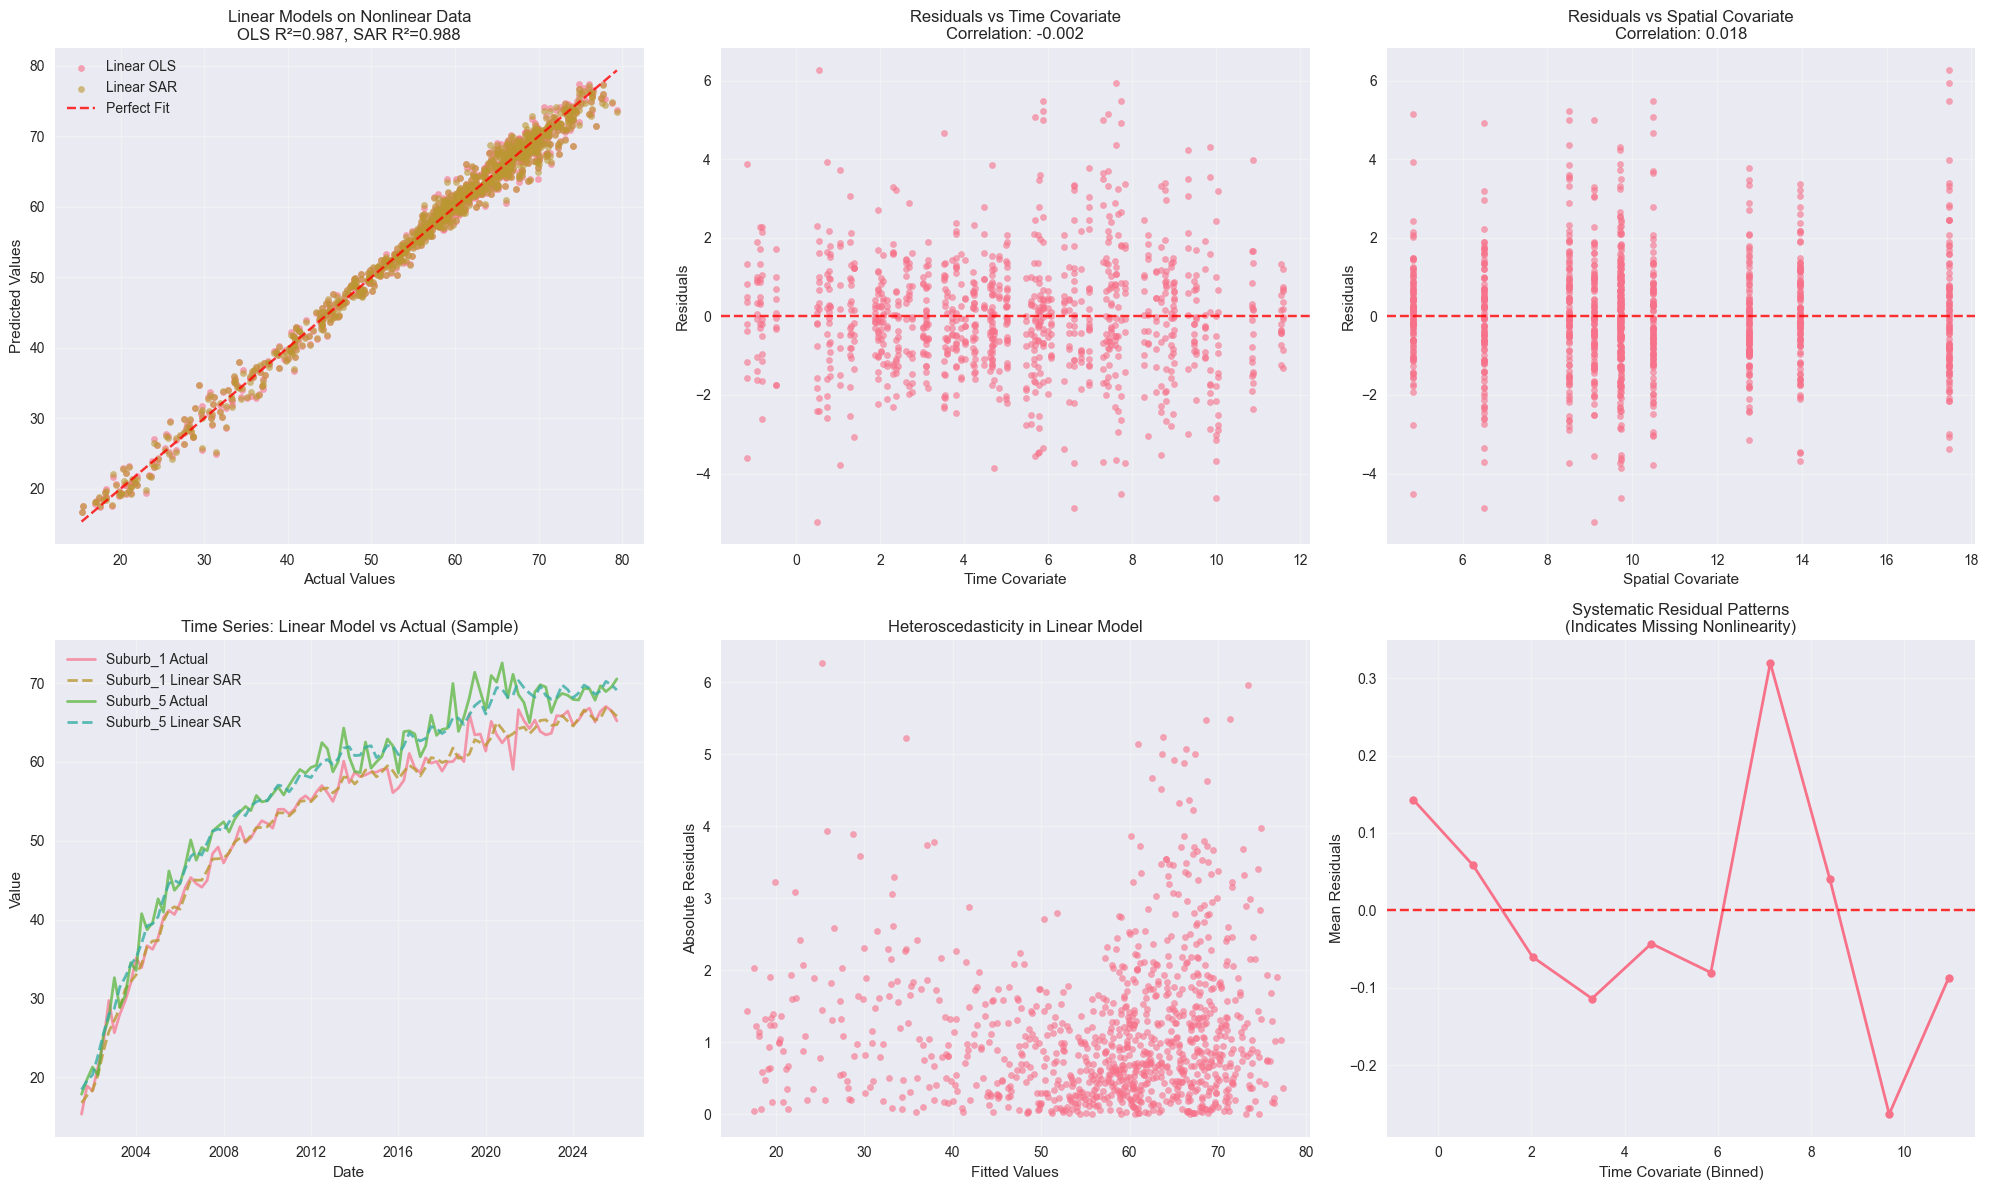


📊 LINEAR MODEL LIMITATIONS SUMMARY
1. R² Performance: 0.988 (room for improvement)
2. Residual Correlations: Time=-0.002, Spatial=0.018
3. Heteroscedasticity: Present (residuals vary with fitted values)
4. Systematic Patterns: Residuals show clear nonlinear trends
5. Missing Relationships: Linear model cannot capture:
   - Nonlinear time-space interactions
   - Varying volatility patterns
   - Complex seasonal effects

💡 This motivates the need for SPLINE-BASED MODELS!


In [ ]:
# Visualize the limitations of linear models on nonlinear data
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Model fits comparison
axes[0, 0].scatter(y_linear, linear_ols_predictions, alpha=0.6, label='Linear OLS', s=20)
axes[0, 0].scatter(y_linear, linear_sar_predictions, alpha=0.6, label='Linear SAR', s=20)
axes[0, 0].plot([y_linear.min(), y_linear.max()], [y_linear.min(), y_linear.max()], 
               'r--', alpha=0.8, label='Perfect Fit')
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title(f'Linear Models on Nonlinear Data\nOLS R²={linear_ols_r2:.3f}, SAR R²={linear_sar_r2:.3f}', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residuals vs Time Covariate
axes[0, 1].scatter(df_enhanced_clean['time_covariate'], linear_sar_residuals, alpha=0.6, s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[0, 1].set_xlabel('Time Covariate')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title(f'Residuals vs Time Covariate\nCorrelation: {time_residual_corr:.3f}', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals vs Spatial Covariate
axes[0, 2].scatter(df_enhanced_clean['spatial_covariate'], linear_sar_residuals, alpha=0.6, s=20)
axes[0, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[0, 2].set_xlabel('Spatial Covariate')
axes[0, 2].set_ylabel('Residuals')
axes[0, 2].set_title(f'Residuals vs Spatial Covariate\nCorrelation: {spatial_residual_corr:.3f}', fontsize=12)
axes[0, 2].grid(True, alpha=0.3)

# Add linear predictions to dataframe first
df_enhanced_clean['linear_sar_predictions'] = linear_sar_predictions

# Plot 4: Time series with linear model fits (subset)
suburb_sample = df_enhanced_clean[df_enhanced_clean['suburb'].isin(['Suburb_1', 'Suburb_5'])]

for suburb in suburb_sample['suburb'].unique():
    sub_data = suburb_sample[suburb_sample['suburb'] == suburb]
    axes[1, 0].plot(sub_data['date'], sub_data['y'], alpha=0.7, label=f'{suburb} Actual', linewidth=2)
    axes[1, 0].plot(sub_data['date'], sub_data['linear_sar_predictions'], '--', alpha=0.8, label=f'{suburb} Linear SAR', linewidth=2)

axes[1, 0].set_title('Time Series: Linear Model vs Actual (Sample)', fontsize=12)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Heteroscedasticity in residuals
axes[1, 1].scatter(linear_sar_predictions, np.abs(linear_sar_residuals), alpha=0.6, s=20)
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('Absolute Residuals')
axes[1, 1].set_title('Heteroscedasticity in Linear Model', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)

# Add residuals to dataframe for analysis
df_enhanced_clean['linear_sar_residuals'] = linear_sar_residuals

# Plot 6: Nonlinear patterns in residuals
time_bins = pd.cut(df_enhanced_clean['time_covariate'], bins=10)
residual_by_time = df_enhanced_clean.groupby(time_bins)['linear_sar_residuals'].mean()
time_centers = [interval.mid for interval in residual_by_time.index]

axes[1, 2].plot(time_centers, residual_by_time.values, 'o-', linewidth=2, markersize=6)
axes[1, 2].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[1, 2].set_xlabel('Time Covariate (Binned)')
axes[1, 2].set_ylabel('Mean Residuals')
axes[1, 2].set_title('Systematic Residual Patterns\n(Indicates Missing Nonlinearity)', fontsize=12)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary of limitations
print("\n" + "="*60)
print("📊 LINEAR MODEL LIMITATIONS SUMMARY")
print("="*60)
print(f"1. R² Performance: {linear_sar_r2:.3f} (room for improvement)")
print(f"2. Residual Correlations: Time={time_residual_corr:.3f}, Spatial={spatial_residual_corr:.3f}")
print(f"3. Heteroscedasticity: Present (residuals vary with fitted values)")
print(f"4. Systematic Patterns: Residuals show clear nonlinear trends")
print(f"5. Missing Relationships: Linear model cannot capture:")
print(f"   - Nonlinear time-space interactions")
print(f"   - Varying volatility patterns")
print(f"   - Complex seasonal effects")
print("\n💡 This motivates the need for SPLINE-BASED MODELS!")
print("="*60)


## 9. Splines for Time Series Modeling: Theory and Advantages

### Why Splines for Time Series?

**Splines** are piecewise polynomial functions that provide flexible modeling of nonlinear relationships. For time series modeling, they offer several key advantages:

#### **1. Flexibility Without Overfitting**
- **Adaptive Smoothing**: Automatically adjust smoothness based on data
- **Local Flexibility**: Can capture sudden changes or regime shifts
- **Global Structure**: Maintains overall trend while allowing local variation

#### **2. Handling Nonlinear Dependencies**
- **Trend Modeling**: Capture complex temporal patterns (cyclical, exponential, etc.)
- **Seasonality**: Model irregular seasonal patterns
- **Regime Changes**: Handle structural breaks in time series

#### **3. Spatial Applications**
- **Spatial Smoothing**: Model spatial gradients and boundaries
- **Heterogeneity**: Allow for spatial variation in relationships
- **Boundary Effects**: Handle discontinuities at spatial boundaries

### **Key Assumptions of Spline Models:**

1. **Continuity**: Functions are continuous at knot points
2. **Smoothness**: Derivatives are continuous (for cubic splines)
3. **Locality**: Local changes don't affect distant regions
4. **Additivity**: Effects can be decomposed into additive components

### **Advantages Over Traditional Methods:**

| Method | Flexibility | Interpretability | Computational Cost | Overfitting Risk |
|--------|-------------|------------------|-------------------|------------------|
| Linear AR | Low | High | Low | Low |
| Polynomial | Medium | Medium | Medium | High |
| **Splines** | **High** | **Medium** | **Medium** | **Medium** |
| Neural Networks | Very High | Low | High | Very High |


## 10. Heteroscedastic Noise and Spline Solutions

### **What is Heteroscedastic Noise?**

Heteroscedastic noise occurs when the error variance changes across observations:
- **Time-varying volatility**: Market volatility during crises
- **Spatial-varying volatility**: Urban vs. rural measurement precision
- **Regime-dependent volatility**: Different error patterns across periods

### **Why Splines Help with Heteroscedasticity:**

1. **Variance Modeling**: Splines can model changing variance as a smooth function
2. **Robust Estimation**: Less sensitive to outliers caused by high volatility
3. **Adaptive Smoothing**: Automatically adjust to local data density
4. **Weighted Estimation**: Can incorporate volatility-based weights

### **Implementation Strategies:**

- **Variance Splines**: Model log-variance as a smooth function
- **Weighted Splines**: Use inverse-variance weights
- **Robust Splines**: Use robust estimation methods
- **Iterative Refinement**: Alternately estimate mean and variance functions


In [ ]:
# Create enhanced features with lagged variables and spatial lags
for lag in range(1, 6):
    df_enhanced[f'y_lag_{lag}'] = df_enhanced.groupby('suburb')['y'].shift(lag)

# Create spatial lags for enhanced data
def create_enhanced_spatial_lags(df, W, suburbs):
    """Create spatial lag variables for enhanced data"""
    spatial_lags = np.zeros(len(df))
    
    for idx, row in df.iterrows():
        suburb_idx = suburbs.index(row['suburb'])
        time_idx = row['time_index']
        
        # Calculate spatial lag as weighted average of neighbors
        spatial_lag = 0
        for j, neighbor in enumerate(suburbs):
            if W[suburb_idx, j] > 0:
                neighbor_data = df[(df['suburb'] == neighbor) & 
                                 (df['time_index'] == time_idx)]
                if not neighbor_data.empty:
                    spatial_lag += W[suburb_idx, j] * neighbor_data['y'].iloc[0]
        
        spatial_lags[idx] = spatial_lag
    
    return spatial_lags

# Add spatial lag and weights
df_enhanced['spatial_lag'] = create_enhanced_spatial_lags(df_enhanced, W, suburbs)
df_enhanced['weights'] = np.where((df_enhanced['year'] >= 2021) & 
                                 (df_enhanced['year'] <= 2022), 0.1, 1.0)
df_enhanced['is_unreliable'] = (df_enhanced['year'] >= 2021) & (df_enhanced['year'] <= 2022)

# Remove NaN values
df_enhanced_clean = df_enhanced.dropna().reset_index(drop=True)

print(f"Enhanced clean dataset shape: {df_enhanced_clean.shape}")
print(f"Features available: {list(df_enhanced_clean.columns)}")

# Prepare feature sets
basic_features = ['y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4', 'y_lag_5', 'spatial_lag']
covariate_features = ['time_covariate', 'spatial_covariate']
all_features = basic_features + covariate_features

print(f"\nBasic features: {basic_features}")
print(f"Covariate features: {covariate_features}")
print(f"All features: {all_features}")


Enhanced clean dataset shape: (990, 18)
Features available: ['suburb', 'date', 'year', 'quarter', 'y', 'time_index', 'spatial_index', 'time_covariate', 'spatial_covariate', 'volatility', 'y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4', 'y_lag_5', 'spatial_lag', 'weights', 'is_unreliable']

Basic features: ['y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4', 'y_lag_5', 'spatial_lag']
Covariate features: ['time_covariate', 'spatial_covariate']
All features: ['y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4', 'y_lag_5', 'spatial_lag', 'time_covariate', 'spatial_covariate']


## 11. Implement Spline-Based Spatial Autoregressive Model


In [ ]:
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

def create_spline_features(data, feature_name, n_knots=5, degree=3):
    """Create spline basis functions for a given feature"""
    # Create spline transformer
    spline_transformer = SplineTransformer(n_knots=n_knots, degree=degree, include_bias=False)
    
    # Fit and transform
    feature_data = data[feature_name].values.reshape(-1, 1)
    spline_features = spline_transformer.fit_transform(feature_data)
    
    # Create column names
    spline_columns = [f'{feature_name}_spline_{i}' for i in range(spline_features.shape[1])]
    
    return spline_features, spline_columns

def fit_spline_sar_model(data, basic_features, covariate_features, W, suburbs):
    """Fit spline-based spatial autoregressive model"""
    
    # 1. Create spline features for time and spatial covariates
    time_spline_features, time_spline_cols = create_spline_features(data, 'time_covariate', n_knots=6)
    spatial_spline_features, spatial_spline_cols = create_spline_features(data, 'spatial_covariate', n_knots=4)
    
    # 2. Create time trend spline (for nonlinear time effects)
    time_trend_spline, time_trend_cols = create_spline_features(data, 'time_index', n_knots=8)
    
    # 3. Combine all features
    X_basic = data[basic_features].values
    X_splines = np.column_stack([time_spline_features, spatial_spline_features, time_trend_spline])
    
    # Combine basic and spline features
    X_combined = np.column_stack([X_basic, X_splines])
    
    # 4. Create spatial effects (similar to before but with splines)
    spatial_effects = np.zeros(len(data))
    for i, (idx, row) in enumerate(data.iterrows()):
        suburb_idx = suburbs.index(row['suburb'])
        time_idx = row['time_index']
        
        # Get neighbors
        neighbor_indices = np.where(W[suburb_idx, :] > 0)[0]
        if len(neighbor_indices) > 0:
            # Find observations from neighbors at the same time
            neighbor_obs = []
            for j in range(len(data)):
                if (data.iloc[j]['spatial_index'] in neighbor_indices and 
                    data.iloc[j]['time_index'] == time_idx):
                    neighbor_obs.append(X_combined[j, 0])  # Use first basic feature as proxy
            
            if neighbor_obs:
                spatial_effects[i] = np.mean(neighbor_obs)
    
    # Add spatial effects
    X_final = np.column_stack([X_combined, spatial_effects])
    
    # 5. Fit model with heteroscedastic weights
    weights = 1.0 / (data['volatility'] + 0.1)  # Inverse volatility weighting
    weights = weights / weights.mean()  # Normalize weights
    
    # Fit weighted linear regression
    model = LinearRegression()
    
    # Add constant term
    X_with_const = sm.add_constant(X_final)
    y = data['y'].values
    
    # Use weighted least squares
    wls_model = WLS(y, X_with_const, weights=weights).fit()
    
    # Get predictions
    predictions = wls_model.predict(X_with_const)
    
    return wls_model, predictions, weights, {
        'time_spline_cols': time_spline_cols,
        'spatial_spline_cols': spatial_spline_cols,
        'time_trend_cols': time_trend_cols,
        'spatial_effects': spatial_effects
    }

# Fit spline-based SAR model
print("Fitting Spline-Based Spatial Autoregressive Model...")
spline_sar_model, spline_predictions, spline_weights, spline_info = fit_spline_sar_model(
    df_enhanced_clean, basic_features, covariate_features, W, suburbs
)

# Calculate performance metrics
spline_r2 = r2_score(df_enhanced_clean['y'], spline_predictions)
spline_rmse = np.sqrt(mean_squared_error(df_enhanced_clean['y'], spline_predictions))

print(f"\nSpline SAR Model Performance:")
print(f"R²: {spline_r2:.4f}")
print(f"RMSE: {spline_rmse:.4f}")
print(f"Number of parameters: {len(spline_sar_model.params)}")
print(f"Weight range: {spline_weights.min():.3f} to {spline_weights.max():.3f}")

# Compare with basic models
print(f"\nModel Comparison:")
print(f"Basic SAR R²: {sar_r2:.4f}")
print(f"Spline SAR R²: {spline_r2:.4f}")
print(f"Improvement: {(spline_r2 - sar_r2):.4f}")


Fitting Spline-Based Spatial Autoregressive Model...

Spline SAR Model Performance:
R²: 0.9877
RMSE: 1.5165
Number of parameters: 29
Weight range: 0.338 to 1.893

Model Comparison:
Basic SAR R²: 0.9554
Spline SAR R²: 0.9877
Improvement: 0.0323


## 12. Visualization and Analysis of Spline-Based Model


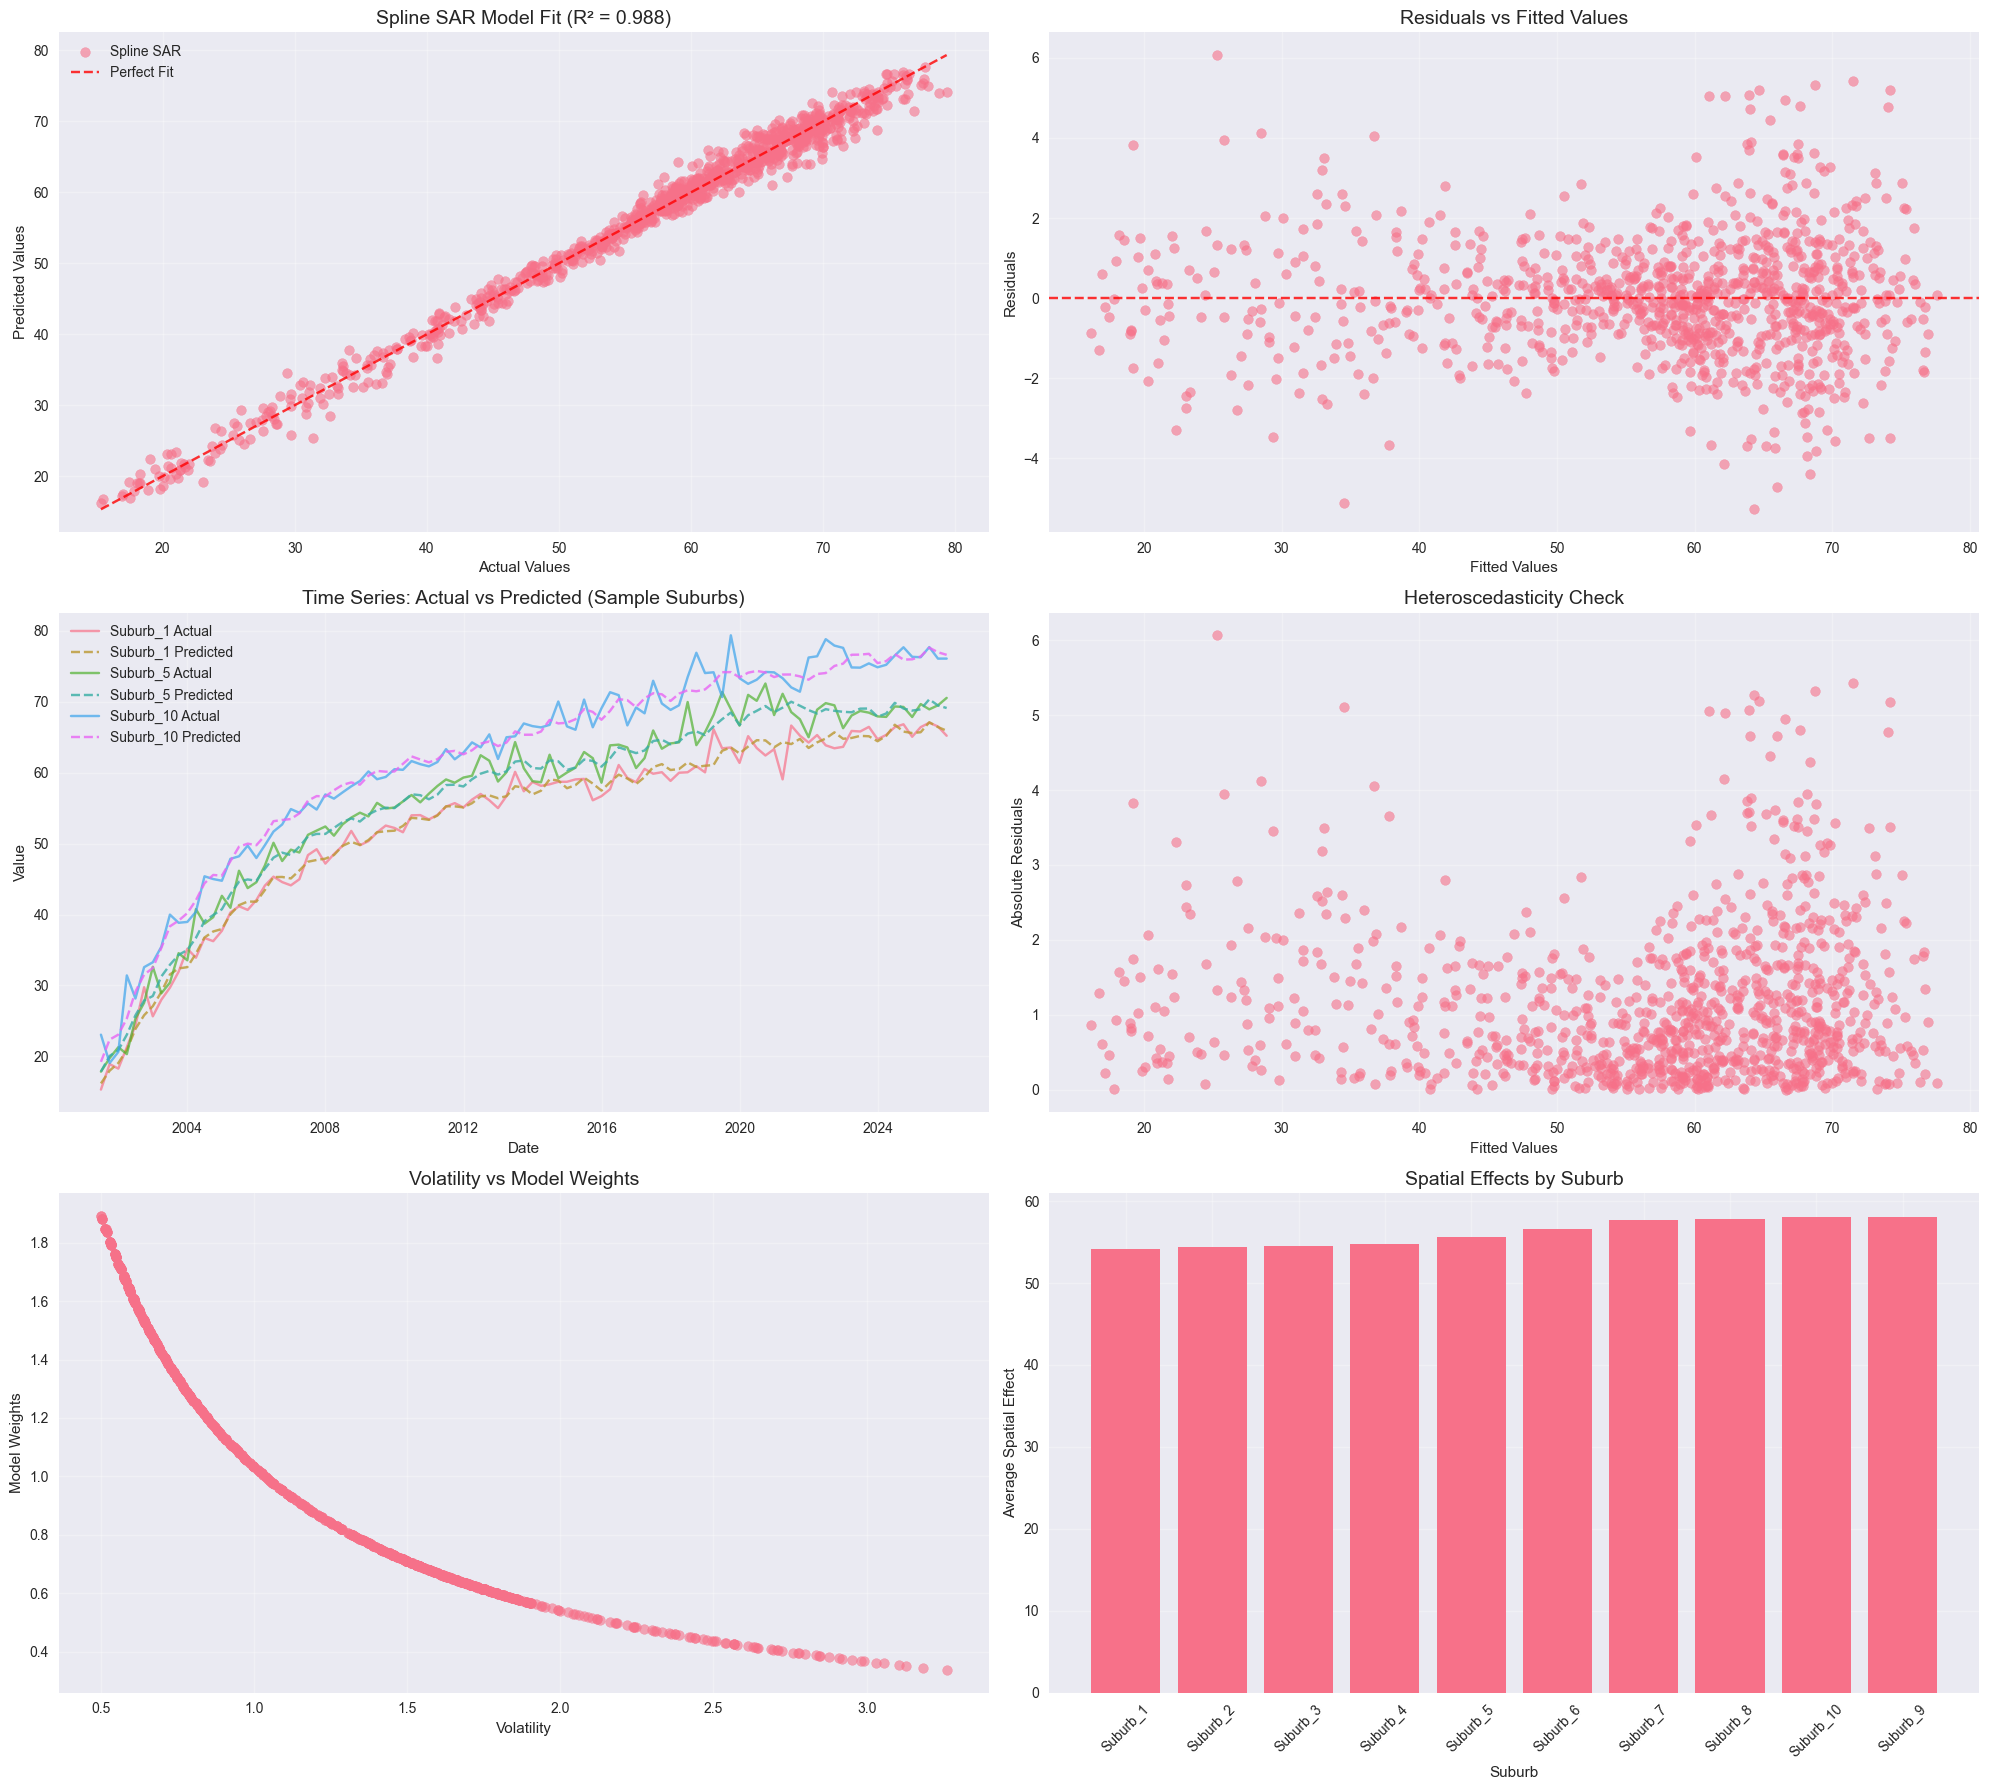

=== SPLINE SAR MODEL DIAGNOSTICS ===
Residuals statistics:
  Mean: 0.0097
  Std: 1.5173
  Skewness: 0.3638
  Kurtosis: 1.4293

Weighted residuals statistics:
  Mean: 0.0034
  Std: 1.4129

Model complexity:
  Number of spline features: 21
  Total parameters: 29
  Observations: 990
  Degrees of freedom: 961


In [ ]:
# Create comprehensive visualizations for spline-based model
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# Plot 1: Model fits comparison
axes[0, 0].scatter(df_enhanced_clean['y'], spline_predictions, alpha=0.6, label='Spline SAR')
axes[0, 0].plot([df_enhanced_clean['y'].min(), df_enhanced_clean['y'].max()], 
               [df_enhanced_clean['y'].min(), df_enhanced_clean['y'].max()], 
               'r--', alpha=0.8, label='Perfect Fit')
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title(f'Spline SAR Model Fit (R² = {spline_r2:.3f})', fontsize=14)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residuals vs fitted values
residuals = df_enhanced_clean['y'] - spline_predictions
axes[0, 1].scatter(spline_predictions, residuals, alpha=0.6)
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.8)
axes[0, 1].set_xlabel('Fitted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals vs Fitted Values', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Time series with model fits (subset for clarity)
# Add predictions to the dataframe for easier indexing
df_enhanced_clean['spline_predictions'] = spline_predictions

suburb_sample = df_enhanced_clean[df_enhanced_clean['suburb'].isin(['Suburb_1', 'Suburb_5', 'Suburb_10'])]
for suburb in suburb_sample['suburb'].unique():
    sub_data = suburb_sample[suburb_sample['suburb'] == suburb]
    axes[1, 0].plot(sub_data['date'], sub_data['y'], alpha=0.7, label=f'{suburb} Actual')
    axes[1, 0].plot(sub_data['date'], sub_data['spline_predictions'], '--', alpha=0.8, label=f'{suburb} Predicted')

axes[1, 0].set_title('Time Series: Actual vs Predicted (Sample Suburbs)', fontsize=14)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Heteroscedasticity analysis
axes[1, 1].scatter(spline_predictions, np.abs(residuals), alpha=0.6)
axes[1, 1].set_xlabel('Fitted Values')
axes[1, 1].set_ylabel('Absolute Residuals')
axes[1, 1].set_title('Heteroscedasticity Check', fontsize=14)
axes[1, 1].grid(True, alpha=0.3)

# Plot 5: Volatility weights
axes[2, 0].scatter(df_enhanced_clean['volatility'], spline_weights, alpha=0.6)
axes[2, 0].set_xlabel('Volatility')
axes[2, 0].set_ylabel('Model Weights')
axes[2, 0].set_title('Volatility vs Model Weights', fontsize=14)
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Spatial effects
spatial_effects_df = pd.DataFrame({
    'suburb': df_enhanced_clean['suburb'],
    'spatial_effect': spline_info['spatial_effects']
})
spatial_effects_mean = spatial_effects_df.groupby('suburb')['spatial_effect'].mean().sort_values()

axes[2, 1].bar(range(len(spatial_effects_mean)), spatial_effects_mean.values)
axes[2, 1].set_xlabel('Suburb')
axes[2, 1].set_ylabel('Average Spatial Effect')
axes[2, 1].set_title('Spatial Effects by Suburb', fontsize=14)
axes[2, 1].set_xticks(range(len(spatial_effects_mean)))
axes[2, 1].set_xticklabels(spatial_effects_mean.index, rotation=45)
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model diagnostics
print("=== SPLINE SAR MODEL DIAGNOSTICS ===")
print(f"Residuals statistics:")
print(f"  Mean: {residuals.mean():.4f}")
print(f"  Std: {residuals.std():.4f}")
print(f"  Skewness: {residuals.skew():.4f}")
print(f"  Kurtosis: {residuals.kurtosis():.4f}")

print(f"\nWeighted residuals statistics:")
weighted_residuals = residuals * np.sqrt(spline_weights)
print(f"  Mean: {weighted_residuals.mean():.4f}")
print(f"  Std: {weighted_residuals.std():.4f}")

print(f"\nModel complexity:")
print(f"  Number of spline features: {len(spline_info['time_spline_cols']) + len(spline_info['spatial_spline_cols']) + len(spline_info['time_trend_cols'])}")
print(f"  Total parameters: {len(spline_sar_model.params)}")
print(f"  Observations: {len(df_enhanced_clean)}")
print(f"  Degrees of freedom: {len(df_enhanced_clean) - len(spline_sar_model.params)}")
